In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# INSTALL & IMPORT LIBRARY

In [2]:
!pip install underthesea
!pip install transformers
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 23.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vn

In [3]:
from bs4 import BeautifulSoup
import numpy as np
import re
# from underthesea import word_tokenize
from keras.utils import to_categorical
from transformers import AutoTokenizer
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
import pandas as pd

In [4]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.2.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


--2023-06-22 08:24:37--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.2.jar’

VnCoreNLP-1.2.jar   100%[===================>]  26.14M  --.-KB/s    in 0.08s   

2023-06-22 08:24:40 (310 MB/s) - ‘VnCoreNLP-1.2.jar’ saved [27412703/27412703]

--2023-06-22 08:24:40--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [5]:
from vncorenlp import VnCoreNLP


# PREPROCESSING

## LOAD DATA

In [6]:
class TextNormalize:
    def __init__(self):
        self.vowels_to_ids = {}
        self.vowels_table = [
            ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
            ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
            ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
            ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
            ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
            ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
            ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
            ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'o'],
            ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
            ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
            ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
            ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
        ]
        pass

    def createVowelsTable(self):
        """Create Vowels Table"""
        for i in range(len(self.vowels_table)):
            for j in range(len(self.vowels_table[i]) - 1):
                self.vowels_to_ids[self.vowels_table[i][j]] = (i, j)

    def IsValidVietnameseWord(self,word):
        """Nguyên âm chỉ có thể đứng chung với nguyên âm. Một từ không thể có 2 nguyên âm cách nhau bởi 1 phụ âm"""
        chars = list(word)
        #nguyen am
        vowel_index = -1
        for i in range(len(chars)):
            idx_vowel_table = self.vowels_to_ids.get(chars[i],(-1,-1))[0]
            if idx_vowel_table != -1:
                if vowel_index == -1:
                    vowel_index = i
                else:
                    if i - vowel_index != 1:
                        return False
                    vowel_index = i
        return True

    def WordStandardized(self,word):
        """Standardize Word"""
        if not self.IsValidVietnameseWord(word):
            return word

        chars = list(word)
        vowel_indexes = []

        # tìm vị trí nguyên âm
        qu_or_gi = False
        thanh_dieu = 0
        for i in range(len(chars)):
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[i],(-1,-1))
            if vowel_table_row == -1 :
                continue
            # qu
            if vowel_table_row == 9:
                if i != 0 and chars[i-1] == 'q':
                    chars[i] = 'u'
                    qu_or_gi = True
            # gi
            elif vowel_table_row == 5:
                if i != 0 and chars[i-1] == 'g':
                    chars[i] = 'i'
                    qu_or_gi = True

            # có chứa thanh điệu
            if vowel_table_col != 0:
                thanh_dieu = vowel_table_col
                chars[i] = self.vowels_table[vowel_table_row][0]

            vowel_indexes.append(i)
        # 1 nguyên âm
        if len(vowel_indexes) == 1:
            c = chars[vowel_indexes[0]]
            chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
            return ''.join(chars)

        for idx_vowel in vowel_indexes:
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[idx_vowel],(-1,-1))
            #ê, ơ, ô
            if vowel_table_row == 4 or vowel_table_row == 7 or vowel_table_row == 8:
                c = chars[idx_vowel]
                chars[idx_vowel] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # kiểm tra qu và gi, 2-3 nguyên âm thì nguyên âm thứ 2 chứa dấu
            if qu_or_gi:
                if len(vowel_indexes) == 2 or len(vowel_indexes) == 3:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # 2 nguyên âm
            if len(vowel_indexes) == 2:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[0]]
                    chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            elif len(vowel_indexes) == 3:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

        return ''.join(chars)

    def normalize(self,text):

        #Chuyen sang viet thuong
        text = text.lower()

        # Rút gọn từ kéo dài
        text = re.sub(r'(\w)\1+',r'\1',text)

        # xóa các emoji dư thừa
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'',text) # no emoji

        text = text.split()
        # chuẩn hóa thanh điệu
        for i in range(len(text)):
            text[i] = self.WordStandardized(text[i])

        text = ' '.join(text)

        # xóa space d
        text = re.sub(r"( )\1+",r'\1',text)
        text = re.sub(r"[:)^@!`~%;?(\+\-\'\"]+",r'',text)

        # remove hastag
        text = re.sub("(@[A-Za-z0-9]+)|(#[0-9A-Za-z]+)"," ", text)
        return text

In [7]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
)


# ASPECT SENTIMENT CLASSIFICATION

In [8]:
PRETRAINED_MODEL = "vinai/phobert-base"
SEP = "</s>"
MAX_LEN = 256
BATCH_SIZE = 8

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## SENTENCE ASPECT PAIR

In [10]:
class LoadSentenceAspectData():
    def __init__(self, file_path):
        self.file_path = file_path

        self.data = pd.read_json(file_path)
        self.data = self.data.dropna()
        self.X = []
        self.aspect = []
        self.polarity = []
    def load(self,):
        _len = len(self.data)
        for i in range(_len):

            aspect_terms = self.data.iloc[i,2] #label

            x = self.data.iloc[i,0].strip() #text
            len_aspect = len(self.data.iloc[i,2])
            for j in range(len_aspect):
              aspect = self.data.iloc[i,2][j]['text'] #aspect
              label = self.data.iloc[i,2][j]['labels'][0] #polarity
              if label == 'Conflict':
                continue

              self.aspect.append(convert_unicode(aspect))
              self.polarity.append(label)
              self.X.append(convert_unicode(x))
        return self.X,self.aspect,self.polarity

In [ ]:
sent_asp_data = LoadSentenceAspectData("/content/drive/MyDrive/Đồ án KHDL/data.json")
sentences, aspects,polarities = sent_asp_data.load()

In [ ]:
len(sentences),len(polarities)

(18023, 18023)

In [ ]:
np.unique(polarities)

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [11]:
# nếu nhiều ý positive hơn neutral 1 tí thì làm tròn positive
tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
idx2tag = {v:k for k,v in tag2idx.items()}


In [12]:
def remove_duplicate_aspects(sentences,aspects,polarities):
  """
    Remove and get mean with duplicate aspects
  """
  df = pd.DataFrame({"Sentences":sentences,"Aspect":aspects,"Polarity":polarities})
  df['Polarity'] = df['Polarity'].apply(lambda x: tag2idx[x])
  gp = df.groupby(by = ['Sentences',"Aspect"])['Polarity'].agg(lambda x: np.ceil(pd.Series.mean(x))).reset_index()
  gp['Polarity'] = gp['Polarity'].astype(int).apply(lambda x: idx2tag[x])

  sents = gp['Sentences'].values
  asps = gp['Aspect'].values
  polars = gp['Polarity'].values
  return sents,asps,polars


In [ ]:
sentences, aspects,polarities = remove_duplicate_aspects(sentences,aspects,polarities)
len(sentences),len(aspects),len(polarities)

(17221, 17221, 17221)

In [ ]:
sentences[:5],aspects[:5],polarities[:5]

(array(['# Cùng giá 30k vs Nghĩa Tân nhưng đây là một bát bên Phùng HưngNhìn đầy đặn vl luôn, đủ cả thịt( rất nhiều thịt) chả cá thơm ngon chứ k tanh tanh mặn mặn như bên Nghĩa Tân, mọc giò cx ngon nữa. Bát bưng ra thơm nức mùi cua vs hành phiĐậu rán có đủ, nhìn kĩ thấy cả gạch cua và hành phi thơm, rau thì phía dưới :)) Nc dùng ngọt và đậm vị cua, bánh đa mềm, thịt chả mọc mọi thứ k chê vào đâu đc, lại còn nhiều. ( khéo ăn hết bánh đa r mà vẫn chưa hết thịt vs chả)Đây là lúc mình còn chưa ăn, tức là chưa cho ớt xào vào mà màu đã hấp dẫn vãi Bên kia lúc bưng ra bát bánh đa trắng phớ, hít mãi chả thấy mùi gì xong mình cho đống ớt vs dấm vào ăn mới thấy có vị',
        '# Cùng giá 30k vs Nghĩa Tân nhưng đây là một bát bên Phùng HưngNhìn đầy đặn vl luôn, đủ cả thịt( rất nhiều thịt) chả cá thơm ngon chứ k tanh tanh mặn mặn như bên Nghĩa Tân, mọc giò cx ngon nữa. Bát bưng ra thơm nức mùi cua vs hành phiĐậu rán có đủ, nhìn kĩ thấy cả gạch cua và hành phi thơm, rau thì phía dưới :)) Nc dùng n

In [ ]:
text_normalize = TextNormalize()
sentences_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),sentences)))
aspects_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),aspects)))

In [13]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')


In [ ]:
sentences_segments = list(map(lambda x:" ".join([" ".join(i) for i in rdrsegmenter.tokenize(x)]),sentences_normalized))
aspects_segments = list(map(lambda x: " ".join(rdrsegmenter.tokenize(x)[0]),aspects_normalized)) #aspect cant not be split


In [ ]:
X_pair = list(zip(sentences_segments,aspects_segments))
X_pair[:5],polarities[:5]

([('# cùng giá 30k vs nghĩa tân_nhưng đây là một bát bên phùng hưngnhìn đầy_đặn vl luôn , đủ cả thịt rất nhiều thịt chả cá thơm ngon chứ k tanh tanh mặn mặn như bên nghĩa tân , mọc giò cx ngon nữa . bát bưng ra thơm_nức mùi cua vs hành phiđậu rán có đủ , nhìn kĩ thấy cả gạch cua và hành phi thơm , rau thì phía dưới nc dùng ngọt và đậm vị cua , bánh_đa mềm , thịt chả mọc mọi thứ k chê vào đâu đc , lại còn nhiều . khéo ăn hết bánh_đa r mà vẫn chưa hết thịt vs chảđây là lúc mình còn chưa ăn , tức_là chưa cho ớt xào vào mà màu đã hấp_dẫn vãi bên kia lúc bưng ra bát bánh_đa trắng phớ , hít mãi chả thấy mùi gì xong mình cho đống ớt vs dấm vào ăn mới thấy có vị',
   'nc dùng'),
  ('# cùng giá 30k vs nghĩa tân_nhưng đây là một bát bên phùng hưngnhìn đầy_đặn vl luôn , đủ cả thịt rất nhiều thịt chả cá thơm ngon chứ k tanh tanh mặn mặn như bên nghĩa tân , mọc giò cx ngon nữa . bát bưng ra thơm_nức mùi cua vs hành phiđậu rán có đủ , nhìn kĩ thấy cả gạch cua và hành phi thơm , rau thì phía dưới nc 

In [ ]:
def find_train_size(X):
  for i in range(len(X),0,-1):
    if i % BATCH_SIZE == 0:
      return i

In [ ]:
X_pair = X_pair[:find_train_size(X_pair)]
polarities = polarities[:find_train_size(X_pair)]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_pair, polarities, test_size=0.21, random_state=42)

In [ ]:
X_train[:5],y_train[:5]

([('ốc ăn cũng ko đặc_sắc lắm , được cái có mùi lá chanh thơm , ốc cũng nhiều ngồi lể mệt muốn chết . quán vỉa_hè nên cũng thoáng mát . một tô ốc đủ cho 2 bạn ngồi lể giá 35k nhé',
   'ốc'),
  ('cháo ếch chỗ này cũng khá nỗi tiếng , cũng có mấy chi_nhánh rồi . chi_nhánh này tuy nằm ở mặt_tiền ngã tư nhưng quán khá nhỏ , cũng may chủ quán có tận_dụng cái vỉa_hè rộng nên chỗ ngồi cũng khá thoáng , chứ ngồi ở trong nhà chật nức mệt lắm . mình order cháo lá dứa ếch singapore , ếch bao ngon , cay_xè ăn rất kích thick . cháo nóng được nẫu nhuyễn , đặc vừa và hoàn_toàn không mùi khôn vị chỉ có thơm tý mùi lá dứa thôi . nhân_viên phục_vụ nhanh_nhẹn nhiệt_tình . giá không hề rẻ đối_với 1 tô cháo ếch , mình ăn sạch_sành_sanh luôn mà vẫn ứ no v',
   'cháo lá dứa'),
  ('review đồ nướng xêko nêm nếm rất vừa , menu phong_phú . đặc_biệt là bẹ sữa vú heo rất ngon vào quán thì nhân_viên đưa menu cho khách tự order order theo số_lượng nhe các bạn / 1 xiên / 5 k khăn ướt chỉ 1 k / khăn khá rẻ so với giá_

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# # <s> context </s> </s> aspect </s>
# def sentence_aspect_pair(X,polarities,tokenizer,batch_size,is_shuffle = False):
#   tag2idx = {"Neutral":1,"Positive":0,"Negative":2}
#   idx2tag = {v:k for k,v in tag2idx.items()}

#   features = {k:[] for k in tokenizer.model_input_names}

#   for i in range(len(X)):
#     token = tokenizer(X[i][0],X[i][1],padding = 'max_length',max_length = MAX_LEN,truncation=True)
#     for name in tokenizer.model_input_names:
#       if name == 'token_type_ids':
#         a = np.asarray(token['input_ids'])
#         first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
#         token_type_id = [[0]* (first[0]+2) + [1] * (end[0]-first[0]-2) + [0]*(MAX_LEN - end[0])]
#         features[name].append(np.asarray(token_type_id[0]))
#         continue
#       temp = np.asarray(token[name]).astype('float')
#       features[name].append(temp)

#   for k,v in features.items():
#     features[k] = np.asarray(features[k])

#   y_encode = list(map(lambda x:tag2idx[x],polarities))
#   y_new = [to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))]

#   dataset = Dataset.from_tensor_slices((features, y_new))
#   if is_shuffle:
#     dataset = dataset.shuffle(buffer_size = len(y_new))
#   dataset = dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#   return dataset

In [15]:
# <s> aspect </s> </s> context </s>
def sentence_aspect_pair(X,polarities,tokenizer,batch_size,is_shuffle = False):
  tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  for i in range(len(X)):
    token = tokenizer(X[i][1],X[i][0],padding = 'max_length',max_length = MAX_LEN,truncation='only_second')
    for name in tokenizer.model_input_names:
      if name == 'token_type_ids':
        a = np.asarray(token['input_ids'])
        first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
        token_type_id = [[0]* (first[0]+1) + [1] * (end[0]-first[0]-1) + [0]*(MAX_LEN - end[0])]
        features[name].append(np.asarray(token_type_id[0]))
        continue
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  y_encode = list(map(lambda x:tag2idx[x],polarities))
  y_new = [to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))]

  dataset = Dataset.from_tensor_slices((features, y_new))
  if is_shuffle:
    dataset = dataset.shuffle(buffer_size = len(y_new))
  dataset = dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

  return dataset

In [ ]:
train = sentence_aspect_pair(X_train,y_train,tokenizer,BATCH_SIZE,is_shuffle=True)
dev = sentence_aspect_pair(X_dev,y_dev,tokenizer,BATCH_SIZE)


In [ ]:
for i in train.take(1):
  print(i[0]['input_ids'][0])
  print(i[0]['token_type_ids'][0])

  print(tokenizer.decode(tf.cast(i[0]['input_ids'][0],tf.int32)))
  print(tokenizer.decode(tf.cast(i[0]['input_ids'][1],tf.int32)))
  print(tokenizer.decode(tf.cast(i[0]['input_ids'][2],tf.int32)))

tf.Tensor(
[0.0000e+00 6.9100e+02 1.4760e+03 2.0000e+00 2.0000e+00 2.0300e+02
 3.2000e+01 1.1685e+04 4.0000e+00 6.9100e+02 1.4760e+03 1.3000e+01
 1.3290e+03 3.4300e+02 1.0294e+04 5.0000e+00 9.9000e+01 2.3000e+02
 1.0000e+01 5.8610e+03 4.7240e+03 4.0000e+00 5.0690e+03 4.0000e+00
 6.9100e+02 1.4760e+03 4.0000e+00 1.1304e+04 5.0000e+00 1.6767e+04
 1.1220e+03 1.1685e+04 5.0000e+00 6.9100e+02 1.4760e+03 5.5160e+03
 8.6680e+03 5.1000e+01 1.3000e+01 1.3290e+03 3.4300e+02 5.0000e+00
 5.8610e+03 4.7240e+03 1.3000e+01 3.2000e+01 3.6000e+01 5.0000e+00
 5.0690e+03 4.7240e+03 1.6400e+02 1.9880e+03 1.1870e+03 2.0110e+04
 1.1816e+04 1.3300e+02 1.3290e+03 8.4000e+01 2.4600e+02 1.5000e+01
 3.9000e+02 4.0000e+00 7.6000e+01 1.8000e+01 3.5100e+02 1.9170e+03
 4.0994e+04 6.8000e+01 5.4300e+02 8.4900e+02 9.4600e+02 8.5000e+01
 4.8000e+01 5.0000e+00 3.7630e+03 1.1110e+03 3.1640e+03 1.5100e+03
 3.7082e+04 2.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000

In [16]:
import transformers
from tensorflow.keras.layers import Input, Dropout, Dense,concatenate,Bidirectional,LSTM,TimeDistributed,Lambda, Embedding
from tensorflow.keras.models import Model


# NO-ASPECT TEMPLATE

### PREPARED NO-ASPECT INPUT

In [17]:
class MaskAspect(object):
    def rolling_window(self,a, window):
      shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
      strides = a.strides + (a.strides[-1],)
      return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    def findFirst_numpy(self,a, b):
      temp = self.rolling_window(a, len(b))
      result = np.where(np.all(temp == b, axis=1))
      return result

    def __call__(self, sample):

        s = sample

        self.input_ids = s['input_ids']
        self.token_type_ids = s['token_type_ids']
        self.attention_mask = s['attention_mask']

        # token_type_ids = [0 0 0 1 1 1 1 1 1 1]
        idx = np.argwhere(self.token_type_ids == 1)
        col_idx = np.split(idx[:, 1], np.unique(idx[:, 0], return_index=True)[1][1:])
        for k in range(len(col_idx)):
          col_idx[k] = np.min(col_idx[k])

        nu = self.input_ids.numpy()
        # print(len(nu),len(col_idx))
        for i in range(len(nu)):

          aspect = nu[i,1:col_idx[i]-1]
          aspect_idx = self.findFirst_numpy(nu[i],aspect)[0]
          for k in range(len(aspect_idx)):
            # print(nu[i],aspect[k])
            nu[i,aspect_idx[k]:aspect_idx[k]+len(aspect)] = tokenizer.convert_tokens_to_ids("<mask>")

          nu[i,1:col_idx[i]-1] = tokenizer.convert_tokens_to_ids("<mask>") #mask

        # self.input_ids = tf.convert_to_tensor(nu)

        s['input_ids'] = nu
        s['token_type_ids'] = self.token_type_ids.numpy().astype(np.float32)
        s['attention_mask'] = self.attention_mask.numpy().astype(np.float32)

        return s



In [18]:
def sentence_aspect_polarity(X,polarities,tokenizer,batch_size,is_shuffle = False):
  """
    Return pretrained input and polarities
  """
  tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  for i in range(len(X)):
    token = tokenizer(X[i][1],X[i][0],padding = 'max_length',max_length = MAX_LEN,truncation='only_second')
    for name in tokenizer.model_input_names:
      if name == 'token_type_ids':
        a = np.asarray(token['input_ids'])
        first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
        token_type_id = [[0]* (first[0]+1) + [1] * (end[0]-first[0]-1) + [0]*(MAX_LEN - end[0])]
        features[name].append(np.asarray(token_type_id[0]))
        continue
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  y_encode = list(map(lambda x:tag2idx[x],polarities))
  y_new = np.asarray([to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))])

  return features,y_new

In [ ]:
X_features_train,y_polarity_train = sentence_aspect_polarity(X_train,y_train,tokenizer,BATCH_SIZE,is_shuffle=True)
X_features_dev,y_polarity_dev = sentence_aspect_polarity(X_dev,y_dev,tokenizer,BATCH_SIZE)

In [ ]:
data_augmentation = tf.keras.layers.Lambda(MaskAspect())
masked_train = data_augmentation(X_features_train)
masked_dev = data_augmentation(X_features_dev)

In [ ]:
X_features_train['input_ids'][0]

array([0.000e+00, 3.211e+03, 2.000e+00, 2.000e+00, 3.211e+03, 2.030e+02,
       3.200e+01, 5.516e+03, 4.319e+03, 9.570e+02, 4.000e+00, 1.100e+01,
       2.240e+02, 1.000e+01, 1.602e+03, 9.610e+02, 3.031e+03, 2.023e+03,
       4.000e+00, 3.211e+03, 3.200e+01, 3.600e+01, 6.630e+02, 1.494e+03,
       1.459e+04, 5.048e+03, 2.020e+02, 3.660e+02, 5.000e+00, 9.460e+02,
       2.478e+03, 7.700e+01, 3.200e+01, 4.810e+03, 2.400e+03, 5.000e+00,
       1.600e+01, 5.281e+03, 3.211e+03, 3.120e+02, 1.300e+01, 7.600e+01,
       8.800e+01, 6.630e+02, 1.494e+03, 1.459e+04, 1.330e+02, 6.639e+03,
       1.947e+03, 2.083e+03, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 

In [ ]:
masked_train['input_ids'][0]

array([0.000e+00, 6.400e+04, 2.000e+00, 2.000e+00, 6.400e+04, 2.030e+02,
       3.200e+01, 5.516e+03, 4.319e+03, 9.570e+02, 4.000e+00, 1.100e+01,
       2.240e+02, 1.000e+01, 1.602e+03, 9.610e+02, 3.031e+03, 2.023e+03,
       4.000e+00, 6.400e+04, 3.200e+01, 3.600e+01, 6.630e+02, 1.494e+03,
       1.459e+04, 5.048e+03, 2.020e+02, 3.660e+02, 5.000e+00, 9.460e+02,
       2.478e+03, 7.700e+01, 3.200e+01, 4.810e+03, 2.400e+03, 5.000e+00,
       1.600e+01, 5.281e+03, 6.400e+04, 3.120e+02, 1.300e+01, 7.600e+01,
       8.800e+01, 6.630e+02, 1.494e+03, 1.459e+04, 1.330e+02, 6.639e+03,
       1.947e+03, 2.083e+03, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 

In [19]:
def toNoASPInput(X_features,masked_data,y_polarity,tokenizer,BATCH_SIZE):
  mask_data = masked_data.copy()
  mask_data["input_ids_mask"] = mask_data.pop("input_ids")
  mask_data["token_type_ids_mask"] = mask_data.pop("token_type_ids")
  mask_data["attention_mask_mask"] = mask_data.pop("attention_mask")

  dataset = Dataset.from_tensor_slices(((X_features,mask_data),{"contrast_out":y_polarity,"polarity_out":y_polarity,"token_out":X_features['input_ids']}))
  dataset = dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

In [ ]:
dataset_train = toNoASPInput(X_features_train,masked_train,y_polarity_train,tokenizer,BATCH_SIZE)
dataset_dev = toNoASPInput(X_features_dev,masked_dev,y_polarity_dev,tokenizer,BATCH_SIZE)

In [ ]:
dataset_train

<_PrefetchDataset element_spec=(({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None)}, {'input_ids_mask': TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), 'token_type_ids_mask': TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), 'attention_mask_mask': TensorSpec(shape=(None, 256), dtype=tf.float32, name=None)}), {'contrast_out': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'polarity_out': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'token_out': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None)})>

## COMPONENT

In [20]:
class ContrastiveLoss(tf.keras.losses.Loss):
  def __init__(self,batch_size,temperature=0.07,**kwargs):
    super().__init__()
    self.temperature = temperature
    self.batch_size = batch_size
    self.cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
    self.cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)
    self.criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.SUM)

  def _cosine_simililarity_dim1(self,x, y):
      v = self.cosine_sim_1d(x, y)
      return v

  def _cosine_simililarity_dim2(self,x, y):
      # x shape: (N, 1, C)
      # y shape: (1, 2N, C)
      # v shape: (N, 2N)
      v = self.cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
      return v

  def _dot_simililarity_dim1(self,x, y):
      # x shape: (N, 1, C)
      # y shape: (N, C, 1)
      # v shape: (N, 1, 1)
      v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
      return v

  def _dot_simililarity_dim2(self,x, y):
      v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
      # x shape: (N, 1, C)
      # y shape: (1, C, 2N)
      # v shape: (N, 2N)
      return v

  def get_negative_mask(self):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((self.batch_size, 2 * self.batch_size), dtype=bool)
    for i in range(self.batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + self.batch_size] = 0
    return tf.constant(negative_mask)

  def call(self, y_true, y_pred):
    zis = y_pred[0]
    zjs = y_pred[1]

    zis = tf.math.l2_normalize(zis, axis=1)
    zjs = tf.math.l2_normalize(zjs, axis=1)

    l_pos = self._cosine_simililarity_dim1(zis, zjs)
    l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
    l_pos /= self.temperature

    negatives = tf.concat([zjs, zis], axis=0)
    negative_mask = self.get_negative_mask()
    loss = 0.00
    for positives in [zis, zjs]:
        l_neg = self._cosine_simililarity_dim2(positives, negatives)

        labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

        l_neg = tf.boolean_mask(l_neg, negative_mask)
        l_neg = tf.reshape(l_neg, (self.batch_size, -1))
        l_neg /= self.temperature

        logits = tf.concat([l_pos, l_neg], axis=1)
        loss += self.criterion(y_pred=logits, y_true=labels)

    loss = loss / (2 * self.batch_size)
    loss = tf.cast(loss,tf.float32)
    return loss


In [21]:
def encoder():

  inputs = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
  }

  model = transformers.TFAutoModel.from_pretrained(PRETRAINED_MODEL,output_hidden_states=True)
  features = model(inputs).hidden_states
  concat = concatenate(
      tuple([features[i] for i in range(-1,0)]),axis = -1
  )
  # (MAX_LEN, 768*4)
  model = Model(inputs = inputs,outputs = concat)
  return model

In [22]:
base_model = encoder()
base_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134998272  ['attention_mask[0][0]',         
 el)                            thPoolingAndCrossAt               'input_ids[0][0]',          

In [23]:
from tensorflow.keras.layers import Layer

class Combine(Layer):

  def __init__(self,name):
    '''Initializes the instance attributes'''
    super(Combine, self).__init__(name = name)

  def call(self, inputs):
    # h: (batch_size,768)
    # embed: (batch_size,3,768)
    # desired output: (batch_size,3)
    return tf.stack(inputs)


## NO CONTRASTIVE LEARNING


In [54]:
def toNoCLInput(X_features,masked_data,y_polarity,tokenizer,BATCH_SIZE):
  mask_data = masked_data.copy()
  mask_data["input_ids_mask"] = mask_data.pop("input_ids")
  mask_data["token_type_ids_mask"] = mask_data.pop("token_type_ids")
  mask_data["attention_mask_mask"] = mask_data.pop("attention_mask")

  dataset = Dataset.from_tensor_slices(((X_features,mask_data),{"polarity_out":y_polarity,"token_out":X_features['input_ids']}))
  dataset = dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

In [57]:
dataset_nocl_train = toNoCLInput(X_features_train,masked_train,y_polarity_train,tokenizer,BATCH_SIZE)
dataset_nocl_dev = toNoCLInput(X_features_dev,masked_dev,y_polarity_dev,tokenizer,BATCH_SIZE)

In [56]:
base_model = encoder()
base_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  134998272  ['attention_mask[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_ids[0][0]',        

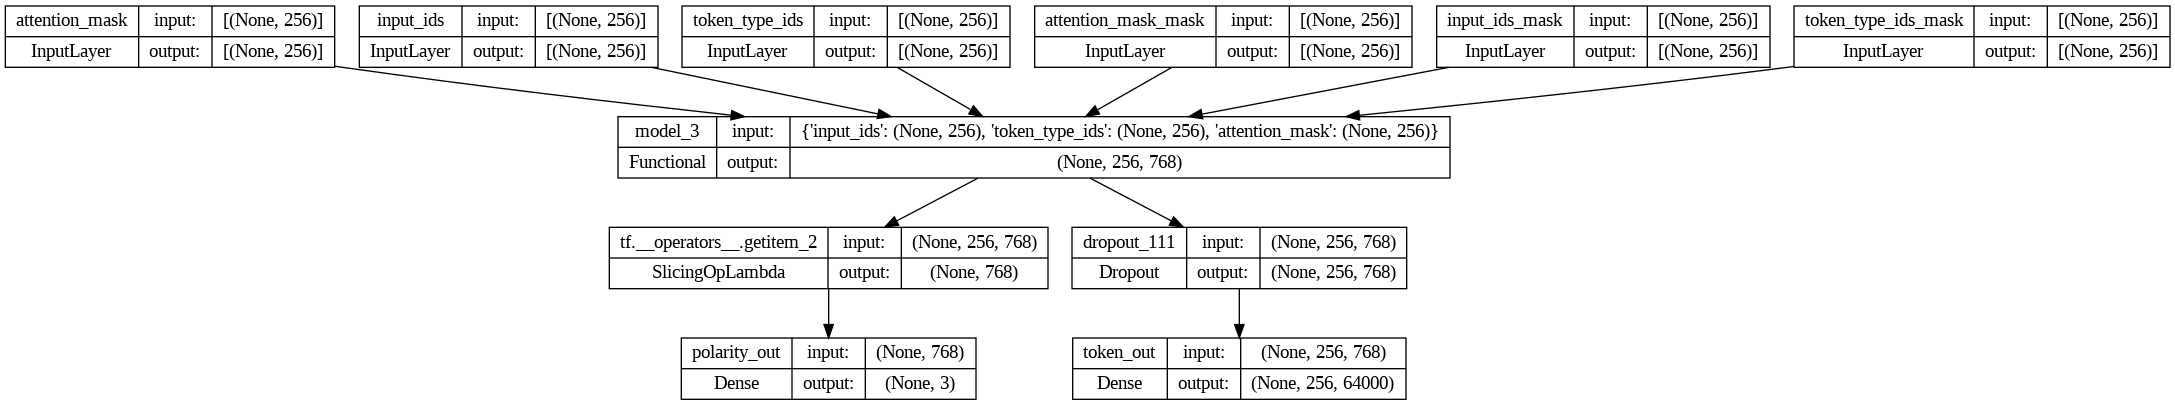

In [58]:
inputs = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
  }

inputs_mask = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids_mask'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids_mask'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask_mask')
  }

contextual_vector_1 = base_model(inputs)
contextual_vector_2 = base_model(inputs_mask)

features_vector_1 = contextual_vector_1[:,0,:]
features_vector_2 = contextual_vector_2[:,0,:]

# Cross-entropy loss
output_sent = Dense(3,activation='softmax',name = 'polarity_out')(features_vector_1)

# Mask Aspect Prediction
dropout = Dropout(0.2) (contextual_vector_2)
output_mask = Dense(tokenizer.vocab_size,activation = 'softmax',name = 'token_out') (dropout)

no_cl_model = Model(inputs = [inputs,inputs_mask],outputs = [output_sent,output_mask])

tf.keras.utils.plot_model(no_cl_model, show_shapes=True)

In [ ]:
no_cl_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 attention_mask_mask (InputLaye  [(None, 256)]       0           []                               
 r)                                                                                         

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_polarity_out_loss',
    patience = 5,
    restore_best_weights = True
    )

In [ ]:
losses = {
    "polarity_out": 'categorical_crossentropy',
    'token_out':'sparse_categorical_crossentropy'
}
loss_weights = {
    "polarity_out": 1,
    'token_out': 0.4

}

no_cl_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),loss = losses,loss_weights = loss_weights)

no_cl_model.fit(
  dataset_nocl_train,
	validation_data = dataset_nocl_dev,
	epochs=1,
	callbacks = early_stop,
	verbose=1,

)

1700/1700 [==============================] - 2058s 1s/step - loss: 0.4662 - polarity_out_loss: 0.2430 - token_out_loss: 0.5580 - val_loss: 0.6154 - val_polarity_out_loss: 0.4522 - val_token_out_loss: 0.4079


In [ ]:
no_cl_model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/encap.h5")

In [ ]:
no_cl_model.save_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/na_wo_cl-3.h5")

## NO MASKED ASPECT PREDICTION

In [24]:
def toNoMAPInput(X_features,masked_data,y_polarity,tokenizer,BATCH_SIZE):
  mask_data = masked_data.copy()
  mask_data["input_ids_mask"] = mask_data.pop("input_ids")
  mask_data["token_type_ids_mask"] = mask_data.pop("token_type_ids")
  mask_data["attention_mask_mask"] = mask_data.pop("attention_mask")

  dataset = Dataset.from_tensor_slices(((X_features,mask_data),{"contrast_out":y_polarity,"polarity_out":y_polarity}))
  dataset = dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

In [ ]:
dataset_nomap_train = toNoMAPInput(X_features_train,masked_train,y_polarity_train,tokenizer,BATCH_SIZE)
dataset_nomap_dev = toNoMAPInput(X_features_dev,masked_dev,y_polarity_dev,tokenizer,BATCH_SIZE)

In [25]:
base_model = encoder()
base_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134998272  ['attention_mask[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_ids[0][0]',        

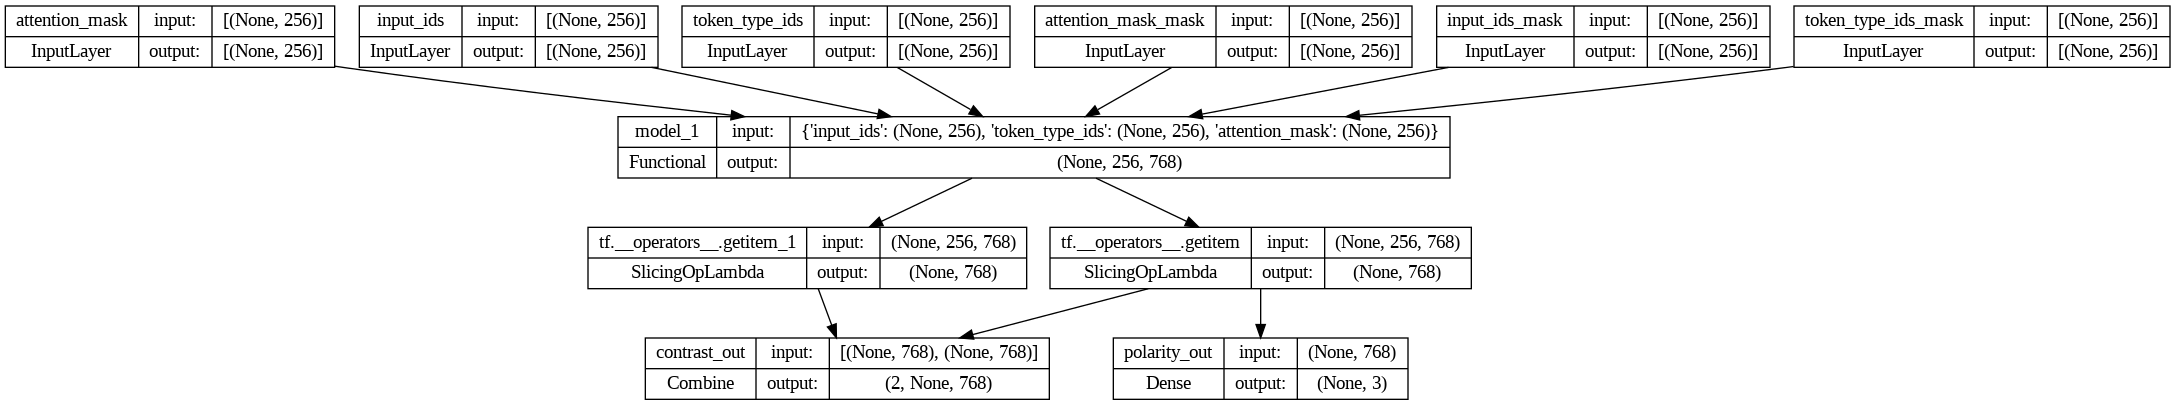

In [26]:
inputs = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
  }

inputs_mask = {
      "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids_mask'),
      "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids_mask'),
      "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask_mask')
  }

contextual_vector_1 = base_model(inputs)
contextual_vector_2 = base_model(inputs_mask)

features_vector_1 = contextual_vector_1[:,0,:]
features_vector_2 = contextual_vector_2[:,0,:]

comb = Combine(name = 'contrast_out') ([features_vector_1,features_vector_2])

# Cross-entropy loss
output_sent = Dense(3,activation='softmax',name = 'polarity_out')(features_vector_1)

no_map_model = Model(inputs = [inputs,inputs_mask],outputs = [comb,output_sent])

tf.keras.utils.plot_model(no_map_model, show_shapes=True)

In [ ]:
no_map_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 attention_mask_mask (InputLaye  [(None, 256)]       0           []                               
 r)                                                                                         

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'val_polarity_out_loss',
    patience = 5,
    restore_best_weights = True
    )

In [ ]:
losses = {
    "contrast_out": ContrastiveLoss(BATCH_SIZE),
    "polarity_out": 'categorical_crossentropy',
}
loss_weights = {
    'contrast_out':0.1,
    "polarity_out": 1,
}

no_map_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),loss = losses,loss_weights = loss_weights)

no_map_model.fit(
  dataset_nomap_train,
	validation_data = dataset_nomap_dev,
	epochs=2,
	callbacks = early_stop,
	verbose=1,

)

Epoch 1/10


 353/1700 [=====>........................] - ETA: 29:06 - loss: 2.3012 - contrast_out_loss: 0.2533 - polarity_out_loss: 0.8425 - token_out_loss: 6.7867

In [ ]:
no_map_model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/na_wo_map-2.h5")

In [ ]:
no_map_model.save_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/encap.h5")

## EVALUATION

In [27]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
  )


In [28]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [29]:
sent_asp_data = LoadSentenceAspectData("/content/drive/MyDrive/Đồ án KHDL/test_300_Quy.json")
sentences, aspects,polarities = sent_asp_data.load()

In [30]:
tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
idx2tag = {v:k for k,v in tag2idx.items()}


In [31]:
sentences, aspects,polarities = remove_duplicate_aspects(sentences,aspects,polarities)


In [32]:
text_normalize = TextNormalize()
sentences_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),sentences)))
aspects_normalized = np.asarray(list(map(lambda x:text_normalize.normalize(x),aspects)))

In [ ]:
sentences_normalized[:5],aspects_normalized[:5]

(array(['bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí. mình hay tới đây ăn vào dịp cuối tuần lắm',
        'bánh bèo chén ở đây rất ấn tượng.bánh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.quán có nhiều thực đơn món ăn phong phú mà giá cả lại rất h

In [33]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')
sentences_segments = list(map(lambda x:" ".join([" ".join(i) for i in rdrsegmenter.tokenize(x)]),sentences_normalized))
aspects_segments = list(map(lambda x: " ".join(rdrsegmenter.tokenize(x)[0]),aspects_normalized)) #aspect cant not be split


In [ ]:
sentences_segments

['bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
 'bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mì

In [34]:
X_pair = list(zip(sentences_segments,aspects_segments))
X_pair[:5],polarities[:5]

([('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'bánh beo'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'bánh bèo chén'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều thực đơn món ăn phong phú mà giá cả lại rất hợp lí . mình hay tới đây ăn vào dịp cuối tuần lắm',
   'giá cả'),
  ('bánh bèo chén ở đây rất ấn tượ ng.ba ́nh beo nhỏ xinh mỏng mỏng ăn kèm tôm cháy đúng điệu phong cách miền trung.qua ́n có nhiều t

In [35]:
def sentence_aspect_polarity(X,polarities,tokenizer,batch_size,is_shuffle = False):
  """
    Return pretrained input and polarities
  """
  tag2idx = {"Neutral":1,"Positive":2,"Negative":0}
  idx2tag = {v:k for k,v in tag2idx.items()}

  features = {k:[] for k in tokenizer.model_input_names}

  for i in range(len(X)):
    token = tokenizer(X[i][1],X[i][0],padding = 'max_length',max_length = MAX_LEN,truncation="only_second")
    for name in tokenizer.model_input_names:
      if name == 'token_type_ids':
        a = np.asarray(token['input_ids'])
        first,end = np.argwhere(a==2)[0],np.argwhere(a==2)[-1]
        token_type_id = [[0]* (first[0]+1) + [1] * (end[0]-first[0]-1) + [0]*(MAX_LEN - end[0])]
        features[name].append(np.asarray(token_type_id[0]))
        continue
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  y_encode = list(map(lambda x:tag2idx[x],polarities))
  y_new = np.asarray([to_categorical(y_encode[i],num_classes = len(tag2idx)) for i in range(len(y_encode))])

  return features,y_new

In [36]:
X_features_test,y_polarity_test = sentence_aspect_polarity(X_pair,polarities,tokenizer,BATCH_SIZE)

In [37]:
data_augmentation = tf.keras.layers.Lambda(MaskAspect())
masked_test = data_augmentation(X_features_test)

In [38]:
y_temp = np.asarray(list(map(lambda x: tag2idx[x],polarities)))
y_temp

array([2, 2, 2, ..., 1, 1, 2])

### NO CONSTRASTIVE LEARNING

In [64]:
no_cl_model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/na_wo_cl-2.h5")

In [65]:
dataset_test = toNoCLInput(X_features_test,masked_test,y_polarity_test,tokenizer,BATCH_SIZE)

In [66]:
y_pred_polarities = []
y_pred_tokens = []
for data in dataset_test:
    y_pred_polarity,y_pred_token = no_cl_model(data[0])
    y_pred_polarity = np.argmax(y_pred_polarity,axis=-1)
    y_pred_token = np.argmax(y_pred_token,axis=-1)
    y_pred_polarities.extend(y_pred_polarity)
    y_pred_tokens.extend(y_pred_token)
    tf.keras.backend.clear_session()

In [67]:
y_pred_polarities = np.asarray(y_pred_polarities)
print(y_pred_polarities)

[2 2 1 ... 1 2 2]


In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_temp, y_pred_polarities,digits = 4))

              precision    recall  f1-score   support

           0     0.7771    0.7439    0.7601       164
           1     0.8507    0.5687    0.6817       932
           2     0.7615    0.9439    0.8429      1319

    accuracy                         0.7855      2415
   macro avg     0.7964    0.7522    0.7616      2415
weighted avg     0.7970    0.7855    0.7751      2415



### NO MASKED ASPECT PREDICTION

In [48]:
no_map_model.load_weights("/content/drive/MyDrive/Đồ án KHDL/ae_checkpoint/na_wo_map.h5")

In [49]:
dataset_test = toNoMAPInput(X_features_test,masked_test,y_polarity_test,tokenizer,BATCH_SIZE)

In [50]:
dataset_test

<_PrefetchDataset element_spec=(({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None)}, {'input_ids_mask': TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), 'token_type_ids_mask': TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), 'attention_mask_mask': TensorSpec(shape=(None, 256), dtype=tf.float32, name=None)}), {'contrast_out': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'polarity_out': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)})>

In [51]:
_,y_pred_polarity = no_map_model.predict(dataset_test)
y_pred_polarity = np.argmax(y_pred_polarity,axis=-1)


302/302 [==============================] - 90s 299ms/step


In [52]:
y_pred_polarities = np.asarray(y_pred_polarity)
print(y_pred_polarities)

[2 2 2 ... 1 2 2]


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_temp, y_pred_polarities,digits = 4))

              precision    recall  f1-score   support

           0     0.6857    0.7317    0.7080       164
           1     0.8508    0.6363    0.7281       932
           2     0.7900    0.9242    0.8519      1319

    accuracy                         0.8000      2415
   macro avg     0.7755    0.7641    0.7626      2415
weighted avg     0.8064    0.8000    0.7943      2415

